In [5]:
import os
import requests
import polars as pl

import glob
import json
import os
from string import Template
from time import sleep
from timeit import default_timer as timer

from dotenv import load_dotenv
from groq import Groq
from neo4j import GraphDatabase
from timeit import default_timer as timer
import glob
import tqdm.notebook as tqdm

In [5]:
cwd = os.getcwd()
# Specify directory to save files
save_dir = 'data'  # Replace with your desired directory path

parameters = {
    "email": "anastasiia.chernavskaia@bse.eu",
    "key": "",
    "country": "Sudan",
    "year": 2025
}

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save files as country_year.csv
country = parameters["country"].replace(" ", "_").lower()
year = parameters["year"]
filename = f"{country}_{year}.csv"
filepath = os.path.join(save_dir, filename)

response = requests.get("https://api.acleddata.com/acled/read.csv", params=parameters)

if response.status_code == 200:
    with open(filepath, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded ACLED CSV data successfully as '{filepath}'.")
else:
    print(f"Error: Received status code {response.status_code}")

acled = pl.read_csv('./data/sudan_2025.csv')
acled.head()

Downloaded ACLED CSV data successfully as 'data/sudan_2025.csv'.


event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,i64,str,str,str,i64,str,i64
"""SUD35177""","""2025-05-16""",2025,2,"""Political violence""","""Explosions/Remote violence""","""Air/drone strike""","""Rapid Support Forces""",null,"""Rebel group""","""Civilians (Sudan)""",null,"""Civilians""","""Rebel group-Civilians""","""Civilian targeting""",729,"""Northern Africa""","""Sudan""","""Khartoum""","""Um Bada""",null,"""Ombada""",15.6477,32.3873,1,"""Al Rakoba News; Twitter""","""New media-National""","""Around 16 May 2025 (as reporte…",0,null,1747690202
"""SUD35220""","""2025-05-16""",2025,1,"""Political violence""","""Battles""","""Government regains territory""","""Military Forces of Sudan (2019…",null,"""State forces""","""Rapid Support Forces""","""SFA: Sudan Founding Alliance""","""Rebel group""","""State forces-Rebel group""",null,729,"""Northern Africa""","""Sudan""","""South Kordofan""","""Abu Jubayhah""",null,"""Ad Dakka""",11.2752,31.0906,1,"""Sudan Tribune; Sudan War Updat…","""National""","""On 16 May 2025, clashes betwee…",0,null,1747690203
"""SUD35221""","""2025-05-16""",2025,1,"""Political violence""","""Explosions/Remote violence""","""Shelling/artillery/missile att…","""SPLM-N-Abdelaziz: Sudan People…",null,"""Rebel group""","""Civilians (Sudan)""",null,"""Civilians""","""Rebel group-Civilians""","""Civilian targeting""",729,"""Northern Africa""","""Sudan""","""South Kordofan""","""Kadugli""",null,"""Kadugli""",11.0142,29.7294,1,"""Sudan Tribune; Sudan War Updat…","""National""","""On 16 May 2025, SPLM-N-Abdelaz…",10,null,1747690203
"""SUD35229""","""2025-05-16""",2025,1,"""Political violence""","""Explosions/Remote violence""","""Air/drone strike""","""Military Forces of Sudan (2019…",null,"""State forces""","""Rapid Support Forces""",null,"""Rebel group""","""State forces-Rebel group""",null,729,"""Northern Africa""","""Sudan""","""North Darfur""","""Al Fasher""",null,"""El Fasher""",13.6264,25.3559,1,"""Muammar Ibrahim; WikiLeaks - E…","""New media""","""On 16 May 2025, SAF fighter dr…",0,null,1747690203
"""SUD35237""","""2025-05-16""",2025,1,"""Political violence""","""Battles""","""Armed clash""","""Military Forces of Sudan (2019…",null,"""State forces""","""Rapid Support Forces""",null,"""Rebel group""","""State forces-Rebel group""",null,729,"""Northern Africa""","""Sudan""","""Red Sea""","""Port Sudan""",null,"""Port Sudan""",19.6148,37.2225,1,"""Ghandi Ibrahim; Mohamed Abdera…","""New media""","""On 16 May 2025, clashes betwee…",0,null,1747690203


# PROCESS WITH GROQ

In [ ]:
# LLM API configuration
#groq_api_key = ""

In [23]:
def process_llm(file_prompt, system_msg):
    # Initialize Groq client
    client = Groq(api_key=groq_api_key)
    
    try:
        completion = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {"role": "system", "content": system_msg + " Return ONLY valid JSON."},
                {"role": "user", "content": file_prompt},
            ],
            max_tokens=4000,  
            temperature=0,
        )
        
        nlp_results = completion.choices[0].message.content
        sleep(8)
        
        # Clean up the response to handle potential JSON formatting issues
        # Remove any markdown formatting that might be present
        if "```json" in nlp_results:
            nlp_results = nlp_results.split("```json")[1].split("```")[0].strip()
        elif "```" in nlp_results:
            nlp_results = nlp_results.split("```")[1].split("```")[0].strip()
            
        # Ensure we have valid JSON before returning
        try:
            json.loads(nlp_results) 
            return nlp_results
        except json.JSONDecodeError as je:
            print(f"Invalid JSON response: {je}. Attempting to fix...")
            # Attempt to extract JSON if it's embedded in text
            import re
            json_pattern = r'({[\s\S]*})'
            match = re.search(json_pattern, nlp_results)
            if match:
                potential_json = match.group(1)
                return potential_json
            else:
                raise ValueError(f"Could not extract valid JSON from response: {nlp_results[:100]}...")
            
    except Exception as e:
        print(f"Error calling LLM API: {e}")
        raise


# Function to take 'notes' column from acled df and a prompt template
# and return a json-object of all entities and relationships
def extract_entities_relationships(acled_df, prompt_template):
    start = timer()
    system_msg = "You are a helpful IT-project and account management expert who extracts information from documents."
    print(f"Running pipeline for {len(acled_df)} notes in acled dataframe")
    results = []
    for i, note in enumerate(acled_df['notes']):
        print(f"Extracting entities and relationships for note {i+1}")
        try:
            prompt = Template(prompt_template).substitute(ctext=note)
            result = process_llm(prompt, system_msg=system_msg)
            results.append(json.loads(result))
        except Exception as e:
            print(f"Error processing note {i+1}: {e}")
    end = timer()
    print(f"Pipeline completed in {end-start} seconds")
    return results



# Function to take a json-object of entitites and relationships and generate cypher query for creating those entities
def generate_cypher(json_obj):
    e_statements = []
    r_statements = []

    e_label_map = {}
    missing_entities = set()

    # loop through our json object
    for i, obj in enumerate(json_obj):
        print(f"Generating cypher for file {i+1} of {len(json_obj)}")
        if "entities" in obj:
            for entity in obj["entities"]:
                label = entity["label"]
                id = entity["id"]
                id = id.replace("-", "").replace("_", "")
                properties = {k: v for k, v in entity.items() if k not in ["label", "id"]}

                cypher = f'MERGE (n:{label} {{id: "{id}"}})'
                if properties:
                    props_str = ", ".join(
                        [f'n.{key} = "{val}"' for key, val in properties.items()]
                    )
                    cypher += f" ON CREATE SET {props_str}"
                e_statements.append(cypher)
                e_label_map[id] = label

        if "relationships" in obj:
            for rs in obj["relationships"]:
                try:
                    src_id, rs_type, tgt_id = rs.split("|")
                    src_id = src_id.replace("-", "").replace("_", "")
                    tgt_id = tgt_id.replace("-", "").replace("_", "")

                    # Check if both source and target entities exist
                    if src_id not in e_label_map:
                        missing_entities.add(src_id)
                        e_label_map[src_id] = "MissingEntity"
                        # Create the missing entity
                        e_statements.append(f'MERGE (n:MissingEntity {{id: "{src_id}"}})')
                        
                    if tgt_id not in e_label_map:
                        missing_entities.add(tgt_id)
                        e_label_map[tgt_id] = "MissingEntity"
                        # Create the missing entity
                        e_statements.append(f'MERGE (n:MissingEntity {{id: "{tgt_id}"}})')

                    src_label = e_label_map[src_id]
                    tgt_label = e_label_map[tgt_id]

                    cypher = f'MERGE (a:{src_label} {{id: "{src_id}"}}) MERGE (b:{tgt_label} {{id: "{tgt_id}"}}) MERGE (a)-[:{rs_type}]->(b)'
                    r_statements.append(cypher)
                except Exception as e:
                    print(f"Error processing relationship {rs}: {e}")

    # Log missing entities
    if missing_entities:
        print(f"Warning: Created {len(missing_entities)} missing entities: {', '.join(missing_entities)}")

    with open("cyphers.txt", "w") as outfile:
        outfile.write("\n".join(e_statements + r_statements))

    return e_statements + r_statements


# Final function to bring all the steps together
def ingestion_pipeline(acled_df, prompt_template):
    # Extracting the entities and relationships from the 'notes' column of acled dataframe
    entities_relationships = extract_entities_relationships(acled_df, prompt_template)
    
    # Generate and execute cypher statements
    cypher_statements = generate_cypher(entities_relationships)
    for i, stmt in enumerate(cypher_statements):
        print(f"Executing cypher statement {i+1} of {len(cypher_statements)}")
        try:
            gds.execute_query(stmt)
        except Exception as e:
            with open("failed_statements.txt", "a") as f:
                f.write(f"{stmt} - Exception: {e}\n")
    
    return cypher_statements




In [12]:
# Prompt for processing ACLED conflict event notes
acled_prompt_template = """
From the conflict event note below, extract the following Entities & relationships described in the mentioned format 
0. ALWAYS FINISH THE OUTPUT. Never send partial responses
1. First, identify the actors and generate entities in comma-separated format as per the entity types below.
   `id` property of each entity must be alphanumeric and unique among entities. This property will be used to define relationships.
    Entity Types:
    label:'Actor',id:string,name:string,type:string //Actor involved in the conflict event; `id` property should be in camelCase; 'name' is the actor's full name as mentioned in the text; 'type' should identify whether they are an armed group, government forces, civilians, etc.
    
2. Next generate each relationship as triples of head, relationship and tail. To refer to the head and tail entity, use their respective `id` property. 
    Relationship types (include as many as apply):
    actor1id|ATTACKS|actor2id
    actor1id|ABDUCTS|actor2id
    actor1id|KILLS|actor2id
    actor1id|INJURES|actor2id
    actor1id|FIGHTS|actor2id
    actor1id|DESTROYS|actor2id

3. The output should look like:
{
    "entities": [
        {"label":"Actor","id":"rsf","name":"Rapid Support Forces","type":"armed group"},
        {"label":"Actor","id":"civilians","name":"Civilians","type":"civilian"}
    ],
    "relationships": ["rsf|ATTACKS|civilians", "rsf|INJURES|civilians"]
}

Conflict Event Note:
$ctext
"""


In [24]:
# Remove rows with empty notes
acled_mini = acled.drop_nulls(subset=['notes']).head(10)

# Run the pipeline on the ACLED data
cypher_statements = ingestion_pipeline(acled_mini, acled_prompt_template)

print(f"Generated {len(cypher_statements)} cypher statements")

Running pipeline for 10 notes in acled dataframe
Extracting entities and relationships for note 1
Extracting entities and relationships for note 2
Invalid JSON response: Expecting ',' delimiter: line 9 column 75 (char 508). Attempting to fix...
Error processing note 2: Expecting ',' delimiter: line 9 column 75 (char 508)
Extracting entities and relationships for note 3
Extracting entities and relationships for note 4
Extracting entities and relationships for note 5
Extracting entities and relationships for note 6
Extracting entities and relationships for note 7
Extracting entities and relationships for note 8
Extracting entities and relationships for note 9
Extracting entities and relationships for note 10
Pipeline completed in 87.53978523006663 seconds
Generating cypher for file 1 of 9
Generating cypher for file 2 of 9
Generating cypher for file 3 of 9
Generating cypher for file 4 of 9
Generating cypher for file 5 of 9
Generating cypher for file 6 of 9
Generating cypher for file 7 of 

In [25]:
cypher_statements

['MERGE (n:Actor {id: "rsf"}) ON CREATE SET n.name = "Rapid Support Forces", n.type = "armed group"',
 'MERGE (n:Actor {id: "civilians"}) ON CREATE SET n.name = "Civilians", n.type = "civilian"',
 'MERGE (n:Actor {id: "splmNAbdelaziz"}) ON CREATE SET n.name = "SPLM-N-Abdelaziz"',
 'MERGE (n:civilians {id: "civilians"}) ON CREATE SET n.name = "Civilians", n.type = "civilians"',
 'MERGE (n:Actor {id: "saf"}) ON CREATE SET n.name = "SAF", n.type = "government forces"',
 'MERGE (n:Actor {id: "rsf"}) ON CREATE SET n.name = "RSF", n.type = "armed group"',
 'MERGE (n:Actor {id: "saf"}) ON CREATE SET n.name = "Sudanese Armed Forces", n.type = "government forces"',
 'MERGE (n:Actor {id: "rsf"}) ON CREATE SET n.name = "Rapid Support Forces", n.type = "armed group"',
 'MERGE (n:Actor {id: "rsf"}) ON CREATE SET n.name = "RSF", n.type = "armed group"',
 'MERGE (n:Actor {id: "saf"}) ON CREATE SET n.name = "SAF", n.type = "armed group"',
 'MERGE (n:Actor {id: "saf"}) ON CREATE SET n.name = "SAF", n.t

# CAST

https://api.acleddata.com/cast/read?key=&email=&country=sudan&year=2025

",
    "key": "

In [2]:
import polars as pl

In [6]:
import requests
import pandas as pd

# Set up API parameters
parameters = {
    "email": "",  # Required: your registered email
    "key": "",  # Required: your API key
    "country": "Sudan",  # Filter by country name
    "event_date": "2025-01-01|2025-05-21",  # Date range in YYYY-MM-DD format
}

# Save files as country_year.csv
country = parameters["country"].replace(" ", "_").lower()
filename = f"{country}_cast.csv"

# GET request to ACLED API (CSV format)
response = requests.get("https://api.acleddata.com/cast/read.csv", params=parameters)

# Process the response
if response.status_code == 200:
    # Option 1: Save CSV directly
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded ACLED CSV data successfully as '{filename}'.")
    
    # Check if response has content
    if len(response.content) > 0:
        # Option 2: Load into polars for analysis
        try:
            # First save to a temporary file, then read with polars
            temp_file = f"temp_{filename}"
            with open(temp_file, 'wb') as f:
                f.write(response.content)
            
            df = pl.read_csv(temp_file)
            os.remove(temp_file)  # Clean up temp file
            
            print(f"Retrieved {df.height} events.")
            print(df.head())
        except Exception as e:
            print(f"Error loading data into polars: {e}")
    else:
        print("Response was successful but contained no data.")
else:
    print(f"Error: Received status code {response.status_code}")
    print(f"Response: {response.text}")


Downloaded ACLED CSV data successfully as 'sudan_cast.csv'.
Retrieved 928 events.
shape: (5, 13)
┌─────────┬─────────────┬───────────┬──────┬───┬────────────┬────────────┬────────────┬────────────┐
│ country ┆ admin1      ┆ month     ┆ year ┆ … ┆ battles_ob ┆ erv_observ ┆ vac_observ ┆ timestamp  │
│ ---     ┆ ---         ┆ ---       ┆ ---  ┆   ┆ served     ┆ ed         ┆ ed         ┆ ---        │
│ str     ┆ str         ┆ str       ┆ i64  ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i64        │
│         ┆             ┆           ┆      ┆   ┆ i64        ┆ i64        ┆ i64        ┆            │
╞═════════╪═════════════╪═══════════╪══════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ Sudan   ┆ Khartoum    ┆ August    ┆ 2025 ┆ … ┆ null       ┆ null       ┆ null       ┆ 1746702919 │
│ Sudan   ┆ Khartoum    ┆ September ┆ 2025 ┆ … ┆ null       ┆ null       ┆ null       ┆ 1746702919 │
│ Sudan   ┆ Khartoum    ┆ October   ┆ 2025 ┆ … ┆ null       ┆ null       ┆ null       ┆ 1746702

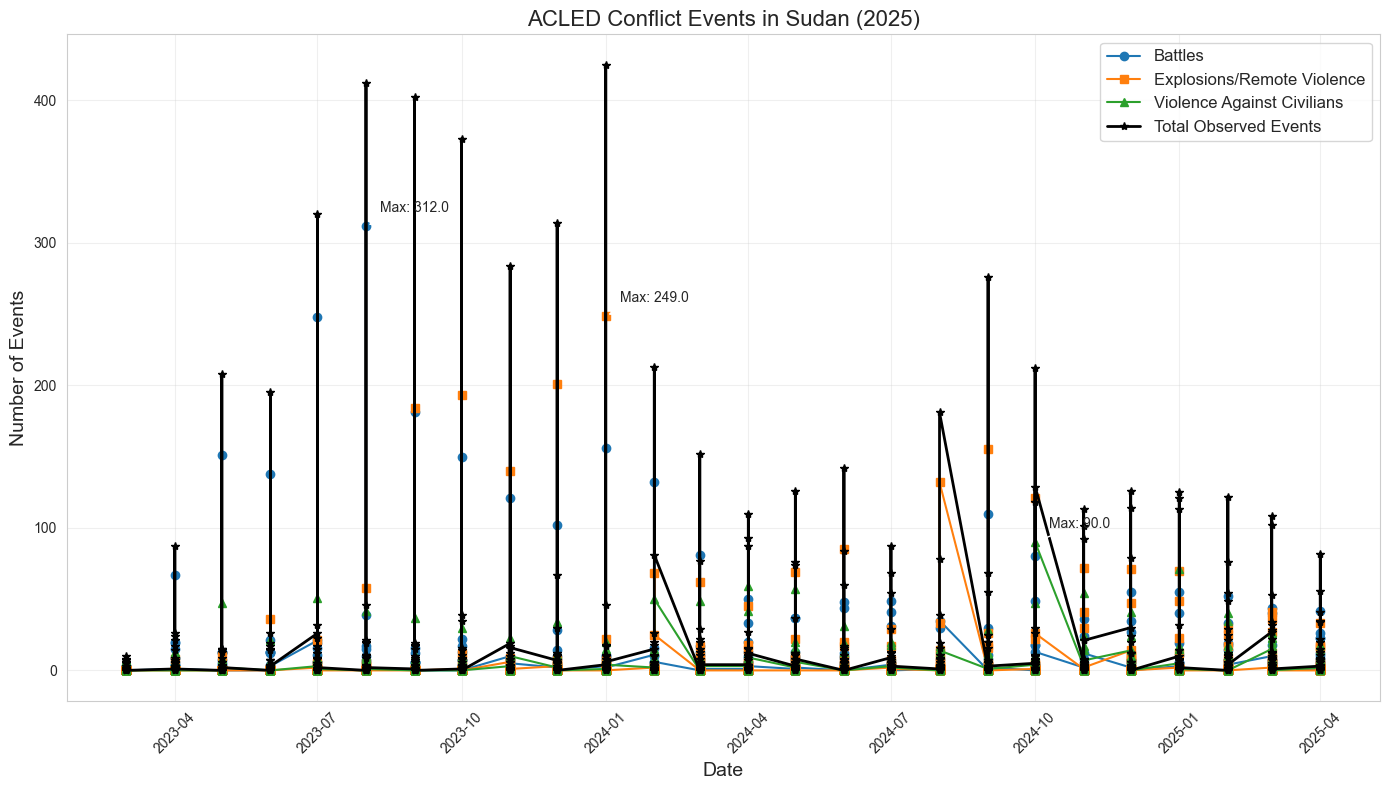

In [7]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Convert to pandas for easier plotting with matplotlib
sudan_pd = df.to_pandas()

# Create a datetime column for proper time series visualization
sudan_pd['date'] = pd.to_datetime(sudan_pd['month'] + ' ' + sudan_pd['year'].astype(str), format='%B %Y')
sudan_pd = sudan_pd.sort_values('date')

# Filter out rows with null values in the observation columns
sudan_pd_filtered = sudan_pd.dropna(subset=['battles_observed', 'erv_observed', 'vac_observed'])

# Create the plot
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

# Plot the three types of observed events
plt.plot(sudan_pd_filtered['date'], sudan_pd_filtered['battles_observed'], marker='o', label='Battles')
plt.plot(sudan_pd_filtered['date'], sudan_pd_filtered['erv_observed'], marker='s', label='Explosions/Remote Violence')
plt.plot(sudan_pd_filtered['date'], sudan_pd_filtered['vac_observed'], marker='^', label='Violence Against Civilians')

# Add total observed line
if 'total_observed' in sudan_pd_filtered.columns:
    plt.plot(sudan_pd_filtered['date'], sudan_pd_filtered['total_observed'], marker='*', 
             linewidth=2, label='Total Observed Events', color='black')

# Set titles and labels
plt.title('ACLED Conflict Events in Sudan (2025)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(fontsize=12)

# Add annotations for maximum values
for col in ['battles_observed', 'erv_observed', 'vac_observed']:
    if not sudan_pd_filtered[col].empty:
        max_val = sudan_pd_filtered[col].max()
        max_idx = sudan_pd_filtered[col].idxmax()
        max_date = sudan_pd_filtered.loc[max_idx, 'date']
        plt.annotate(f'Max: {max_val}', 
                     xy=(max_date, max_val),
                     xytext=(10, 10),
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

In [10]:
peacekeepers = pl.read_excel('/Users/newmac/Downloads/peacekeeping_2025-05-16.xlsx')
peacekeepers

EVENT_ID_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,DISORDER_TYPE,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,ACTOR2,ASSOC_ACTOR_2,INTER2,INTERACTION,CIVILIAN_TARGETING,ISO,REGION,COUNTRY,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TAGS,TIMESTAMP
str,date,i64,i64,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,i64,str,str,str,i64,str,i64
"""XKX1147""",2025-04-01,2025,1,"""Strategic developments""","""Strategic developments""","""Change to group/activity""","""NATO: North Atlantic Treaty Or…","""KFOR: Kosovo Force (1999-); Mi…","""External/Other forces""","""""","""""","""""","""External/Other forces only""","""""",0,"""Europe""","""Kosovo""","""Ferizaj""","""Ferizaj""","""""","""Ferizaj""",42.371,21.155,3,"""KoSSev""","""National""","""Movement of forces: On 1 April…",0,"""""",1744148740
"""XKX1106""",2025-01-24,2025,1,"""Strategic developments""","""Strategic developments""","""Change to group/activity""","""NATO: North Atlantic Treaty Or…","""KFOR: Kosovo Force (1999-); Mi…","""External/Other forces""","""""","""""","""""","""External/Other forces only""","""""",0,"""Europe""","""Kosovo""","""Mitrovica""","""Leposaviq""","""""","""Leposaviq""",43.102,20.801,1,"""KoSSev""","""Subnational""","""Security measures: On 24 Janua…",0,"""""",1747163769
"""XKX1105""",2025-01-18,2025,1,"""Strategic developments""","""Strategic developments""","""Change to group/activity""","""NATO: North Atlantic Treaty Or…","""KFOR: Kosovo Force (1999-); Mi…","""External/Other forces""","""""","""""","""""","""External/Other forces only""","""""",0,"""Europe""","""Kosovo""","""Mitrovica""","""North Mitrovica""","""""","""North Mitrovica""",42.895,20.865,1,"""KoSSev""","""Subnational""","""Movement of forces: On 18 Janu…",0,"""""",1738102195
"""XKX1100""",2025-01-05,2025,1,"""Strategic developments""","""Strategic developments""","""Change to group/activity""","""NATO: North Atlantic Treaty Or…","""KFOR: Kosovo Force (1999-)""","""External/Other forces""","""""","""""","""""","""External/Other forces only""","""""",0,"""Europe""","""Kosovo""","""Mitrovica""","""North Mitrovica""","""""","""North Mitrovica""",42.895,20.865,1,"""KoSSev""","""Subnational""","""Movement of forces: On 5 Janua…",0,"""""",1737435899
"""XKX1075""",2024-11-07,2024,1,"""Strategic developments""","""Strategic developments""","""Change to group/activity""","""NATO: North Atlantic Treaty Or…","""KFOR: Kosovo Force (1999-)""","""External/Other forces""","""""","""""","""""","""External/Other forces only""","""""",0,"""Europe""","""Kosovo""","""Mitrovica""","""North Mitrovica""","""""","""North Mitrovica""",42.895,20.865,3,"""KoSSev""","""Subnational""","""Security measures: On 7 Novemb…",0,"""""",1731510677
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""YEM29413""",2019-03-12,2019,1,"""Political violence""","""Explosions/Remote violence""","""Shelling/artillery/missile att…","""Military Forces of Yemen (2017…","""""","""State forces""","""UNMHA: United Nations Mission …","""""","""External/Other forces""","""State forces-External/Other fo…","""""",887,"""Middle East""","""Yemen""","""Al Hudaydah""","""Al Hali""","""""","""Al Hudaydah - Al Yamani Dairy …",14.78,43.0,1,"""Saudi Press Agency""","""Regional""","""Houthi forces reportedly fired…",0,"""""",1719872686
"""YEM29087""",2019-03-02,2019,1,"""Political violence""","""Battles""","""Armed clash""","""West Coast Joint Forces""","""""","""Political militia""","""UNMHA: United Nations Mission …","""UN: United Nations""","""External/Other forces""","""Political militia-External/Oth…","""""",887,"""Middle East""","""Yemen""","""Al Hudaydah""","""Al Hali""","""""","""Al Hudaydah - Street 50""",14.794,42.999,1,"""Yemen News Agency SABA""","""National""","""On 2 March 2019, anti-Houthi f…",0,"""""",1700527353
"""YEM52570""",2019-02-26,2019,1,"""Political violence""","""Explosions/Remote violence""","""Shelling/artillery/missile at